In [1]:
import math

class Node:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Element(data={self.data:.4f}, grad={self.grad:.4f})"

    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, _children=(self, other), _op='+')
        def _backward_fn():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward_fn
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, _children=(self, other), _op='*')
        def _backward_fn():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward_fn
        return out

    def relu(self):
        out_data = max(0, self.data)
        out = Node(out_data, _children=(self,), _op='ReLU')
        def _backward_fn():
            self.grad += (1 if self.data > 0 else 0) * out.grad
        out._backward = _backward_fn
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Node(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1
        
    def exp(self):
        x = self.data
        out = Node(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def log(self):
        x = self.data
        out = Node(math.log(x) if x > 0 else -float('inf'), (self, ), 'log')
        def _backward():
            self.grad += ((1/x) if x > 0 else 0.0) * out.grad 
        out._backward = _backward
        return out


    def __radd__(self, other): return self + other
    def __rmul__(self, other): return self * other
    def __neg__(self): return self * -1
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)

In [2]:
class Nadam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.m = {p: 0.0 for p in self.params}
        self.v = {p: 0.0 for p in self.params}

    def step(self):
        self.t += 1
        for p in self.params:
            g = p.grad
            
            self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * g
            self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * (g ** 2)

            m_hat = self.m[p] / (1 - self.beta1 ** self.t)
            v_hat = self.v[p] / (1 - self.beta2 ** self.t)
            
            m_nesterov = self.beta1 * m_hat + (1 - self.beta1) * g / (1 - self.beta1 ** self.t)
            
            p.data -= self.lr * m_nesterov / (math.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        for p in self.params:
            p.grad = 0.0

In [3]:
import unittest

class TestNadam(unittest.TestCase):

    def test_nadam_converges_simple(self):
        x = Node(5.0)
        optimizer = Nadam([x], lr=0.1)

        for i in range(250):
            optimizer.zero_grad()
            y = x * x
            y.backward()
            optimizer.step()
            
        self.assertAlmostEqual(x.data, 0.0, places=5)

    def test_nadam_multiple_params(self):
        x = Node(3.0)
        y = Node(-4.0)
        optimizer = Nadam([x, y], lr=0.1)

        for i in range(250):
            optimizer.zero_grad()
            loss = x**2 + y**2
            loss.backward()
            optimizer.step()
        
        self.assertAlmostEqual(x.data, 0.0, places=5)
        self.assertAlmostEqual(y.data, 0.0, places=5)

loader = unittest.TestLoader()
suite = loader.loadTestsFromTestCase(TestNadam)
runner = unittest.TextTestRunner()
runner.run(suite)

F.
FAIL: test_nadam_converges_simple (__main__.TestNadam.test_nadam_converges_simple)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/kn/k7fnf3gj53sbht00y8v6k4900000gn/T/ipykernel_54256/3330181326.py", line 15, in test_nadam_converges_simple
    self.assertAlmostEqual(x.data, 0.0, places=5)
AssertionError: 9.054939144616456e-06 != 0.0 within 5 places (9.054939144616456e-06 difference)

----------------------------------------------------------------------
Ran 2 tests in 0.003s

FAILED (failures=1)


<unittest.runner.TextTestResult run=2 errors=0 failures=1>

Эпоха 10/50, Потери: 0.0689
Эпоха 20/50, Потери: 0.0289
Эпоха 30/50, Потери: 0.0196
Эпоха 40/50, Потери: 0.0158
Эпоха 50/50, Потери: 0.0136

Обучение завершено!
Итоговые веса: w1=1.7214, w2=1.6055
Итоговое смещение: b=-0.2266


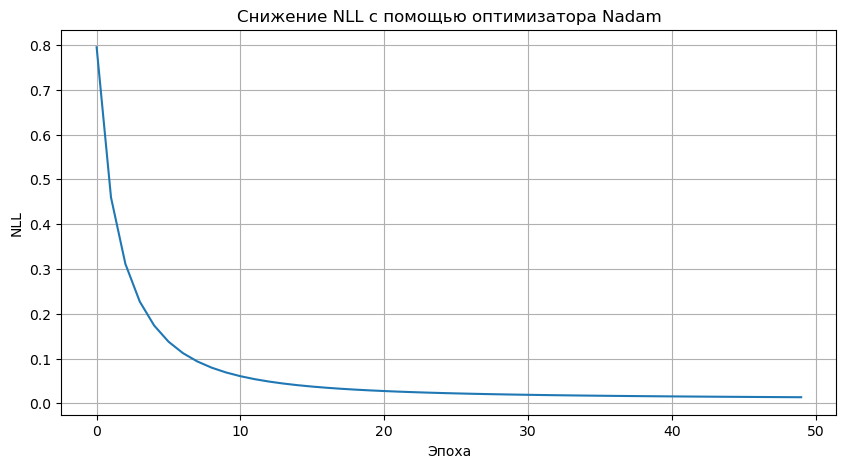

In [4]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
features_data = torch.cat([torch.randn(50, 2) - 2, torch.randn(50, 2) + 2])
labels_data = torch.tensor([0]*50 + [1]*50, dtype=torch.float32)

w1 = Node(0.1)
w2 = Node(-0.2)
b = Node(0.0)
parameters = [w1, w2, b]

optimizer = Nadam(parameters, lr=0.1)

epochs = 50
nll_values = []
epsilon_node = 1e-8

for epoch in range(epochs):
    
    total_loss = Node(0.0)
    
    for i in range(len(features_data)):
        x1_val = features_data[i, 0].item()
        x2_val = features_data[i, 1].item()
        y_val = labels_data[i].item()

        z = w1 * x1_val + w2 * x2_val + b
        a = 1.0 / (1.0 + (-z).exp()) 
        
        loss_i = -(y_val * (a + epsilon_node).log() + (1-y_val) * (1.0 - a + epsilon_node).log())
        total_loss += loss_i
    
    mean_loss = total_loss / len(features_data)
    nll_values.append(mean_loss.data)
    
    optimizer.zero_grad()
    mean_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Эпоха {epoch+1}/{epochs}, Потери: {mean_loss.data:.4f}")

print("\nОбучение завершено!")
print(f"Итоговые веса: w1={w1.data:.4f}, w2={w2.data:.4f}")
print(f"Итоговое смещение: b={b.data:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(nll_values)
plt.title("Снижение NLL с помощью оптимизатора Nadam")
plt.xlabel("Эпоха")
plt.ylabel("NLL")
plt.grid(True)
plt.show()